<h1>Inference on a User 235 of 24 lags, 24 pre-step with two feature on LSTM </h1>

<h2>0.Parameters</h2>

In [153]:
import sys ; sys.path.append('../../util') # add utility folder to a system path
from fresh_parameters import parameters

param = parameters(n_repeats=1, 
                   n_data_period = 1, # 0 means 52 wk, 1 means 3 months, 2 means 4 weeks 3 means 1 week and else is 3 days
                   n_lags=24, 
                   n_seq_steps=24, 
                   n_pre_steps=24, n_features=2, 
                   batch_size=168, forcast_batch_size=1,
                   test_size=24 * 7 * 2, 
                   n_epochs=50, 
                   n_neurons=200,
                   b_stateful = False,
                   b_shuffle = True,
                   ratio_rec_dropout = 0.0, # recurrent dropout ratio
                   ratio_input_dropout = 0.2 , # input dropout ratio
                   ratio_validation=0.2,input_folder = "../../input/electricity/",
                   input_file_01 = "elect_252w_id.csv", debug_folder = "../../debug/",
                   b_load_model = True,
                   model_folder = "model_loc/",
                   model_json = "e235_e250_e252_shuffle_True_test_12wk_model.json",
                   model_weight = "e235_e250_e252_shuffle_True_test_12wk_weight.h5" 
                   )

NEURONS = param.n_neurons

In [154]:
%%javascript
Jupyter.keyboard_manager.command_shortcuts.add_shortcut('r', {
    help : 'run all cells',
    help_index : 'zz',
    handler : function (event) {
        IPython.notebook.execute_all_cells();
        return false;
    }}
);

IPython.keyboard_manager.command_shortcuts.add_shortcut('alt-r',
  function (event) {
      IPython.notebook.kernel.restart();
      setTimeout(function(){ IPython.notebook.execute_all_cells(); }, 1000);
      return false;
});

<IPython.core.display.Javascript object>

In [155]:
import pandas as pd
from fresh_general_util import time_start, time_end, set_seed
start_time = time_start() ; set_seed()

<h2>1. Load an input data and preprocess it</h2>

In [156]:
input_file_01_path = param.input_folder + param.input_file_01
print("input_file_01_path: ",input_file_01_path)

input_file_01_path:  ../../input/electricity/elect_252w_id.csv


In [157]:
#from fresh_input_preprocess import load_input, get_sample_period, sample_dataset
from fresh_input_preprocess import get_sample_period, sample_dataset, load_input_personid
series_raw = load_input_personid(input_file_01_path)
# aggregate electric spendings by hour
series = series_raw.resample("H").mean() ; #print(series.head())
start_date, end_date = get_sample_period(param.n_data_period)
series = sample_dataset(start_date, end_date, series, param.debug_folder, verbose=True)
print(series.head(5))

                       elect_sp  person_id
date                                      
2011-01-03 00:00:00  239.522995      252.0
2011-01-03 01:00:00  242.930161      252.0
2011-01-03 02:00:00  246.337311      252.0
2011-01-03 03:00:00  235.255539      252.0
2011-01-03 04:00:00  233.130325      252.0


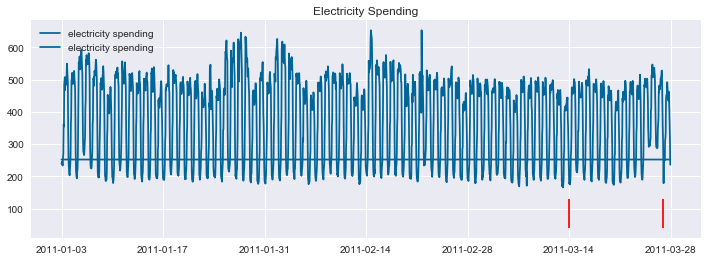

In [158]:
# Show the data set selected
from datetime import date
import matplotlib.pyplot as plt
import seaborn;seaborn.set()
plt.rcParams["figure.figsize"] = [12, 4]
plt.plot(series, label="electricity spending", color = '#006699')
plt.legend(loc='upper left')
plt.title("Electricity Spending")
plt.vlines(x=date(2011,3,14), ymin=40, ymax=130, color='r')
plt.vlines(x=date(2011,3,27), ymin=40, ymax=130, color='r')
plt.show()

<h2>2. Prepare Data using scale abd spliting into train and test</h2>

In [159]:
from numpy import concatenate
import numpy as np
from pandas import concat

from sklearn.preprocessing import MinMaxScaler

In [160]:
import math

In [161]:
from fresh_input_preprocess import prepare_data3, split_X_Y_2, series_to_supervised
# make a train and test data set scaled
scaler, train_scale, val_scale, test_scale = prepare_data3(series, param,verbose=False)

In [162]:
# Split X and Y for Train, Val and Test
x_train_scale, y_train_scale, x_val_scale, y_val_scale, x_test_scale, y_test_scale = split_X_Y_2(train_scale, 
                                                                                                 val_scale, test_scale, 
                                                                                                 param, y_index=2, 
                                                                                                 verbose=False)

<h2>3. Make a model and Experiment</h2>

In [163]:
from fresh_model import display_loss_train, save_model, load_model
from fresh_prediction import fit_lstm2, make_forecasts, forecast_lstm, evaluate_mse, invert_scale, convert_prediction
from fresh_prediction import make_mul_index, predict, predict2
import numpy as np

In [164]:
import sys
def inference(param, neurons, scaler, x_train_scale, y_train_scale, x_val_scale, y_val_scale,x_test_scale, 
               y_test_true, verbose=False):
    
    if param.b_load_model == False:
        print("A status of b_load_model is False")
        sys.exit()

    best_model = load_model(param)
    weights = best_model.get_weights() 
    best_error_score, best_predictions, y_true = predict2(weights,param, scaler, 
            x_test_scale, y_test_true, verbose=verbose )    
                
    return best_error_score, best_predictions, y_true, best_model

In [165]:
best_error_score, best_predictions, y_test_true, best_model = inference(param, param.n_neurons,scaler,x_train_scale,
                                                              y_train_scale,x_val_scale, y_val_scale, 
                                                              x_test_scale, y_test_scale,verbose=False)

type predictions: <class 'numpy.ndarray'>
Shape of predictions: 
 (313, 24)
TEST RMSE: 88.240


<h2>4. Evaluation</h2>

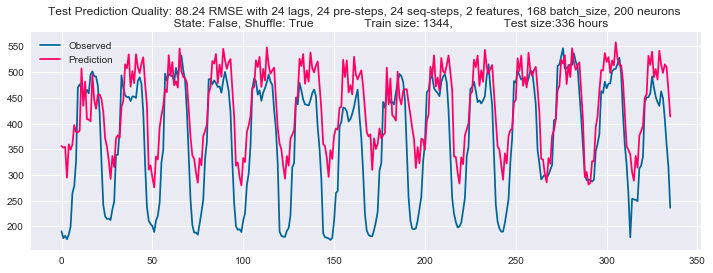

In [166]:
from fresh_prediction import display_obs_pred, evaluate, evaluate_with_model2
display_obs_pred("Test", best_error_score, param, 
                     y_test_true, best_predictions, x_train_scale,TEST_SIZE=param.test_size )    

type predictions: <class 'numpy.ndarray'>
Shape of predictions: 
 (1344, 24)
TEST RMSE: 91.322


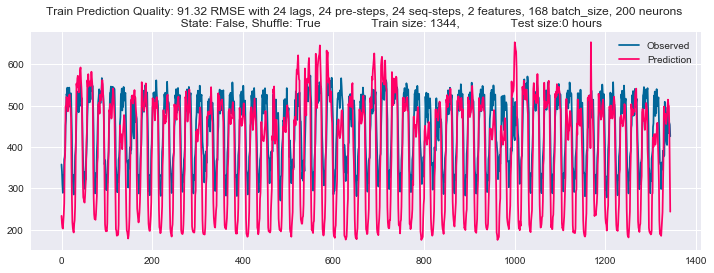

In [167]:
# Evaluate train data    
evaluate_with_model2("Train", best_model, param,scaler,
           x_train_scale, y_train_scale,verbose=False)    
 

type predictions: <class 'numpy.ndarray'>
Shape of predictions: 
 (168, 24)
TEST RMSE: 95.959


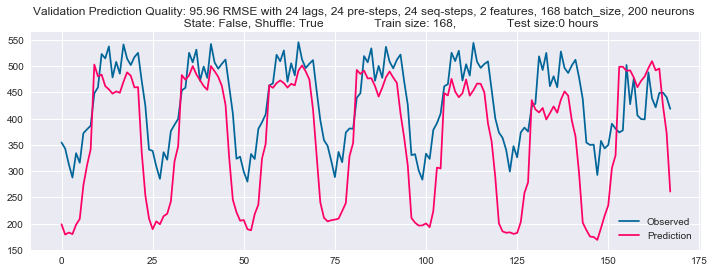

In [168]:
# Evaluate train data    
evaluate_with_model2("Validation", best_model,param,scaler,
           x_val_scale, y_val_scale, verbose=False)   

In [169]:
time_end(start_time)

start time:  1539091411.811893
end time:  1539091442.710562
Total exectution time (Min): 0.5149778167406718


<h3>Reference:</h3><br>